# Assignment 07: Due Monday 10/16

In this assignment we will look at some siumulated $\pi^-$ data from the electron-ion collider (EIC) experiment ePIC. We will use a subset of the ePIC simulation data to assess the tracking performance, specifically the momentum resolutions, of the ePIC tracking system. 

For curious readers interested in seeing the code framework of a developing experiment (not needed for the assignemt)

* ePIC geometry/GEANT simulation code: https://github.com/eic/epic

* ePIC reconstruction code: https://github.com/eic/EICrecon


## Imports 

For this assignemnt you will need the following imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from scipy.optimize import curve_fit
%matplotlib notebook

import scipy.special as sf
import seaborn as sns

# Problem 1A)

Create a Pandas DataFrame object from the data file *epic_3511.csv*, located in the *data* dircetroy, and use the *info* function to list the information from the DataFrame.

In [2]:
inpath = %pwd
infile = inpath +'/data/epic_3511.csv'
print(infile)

df = pd.read_csv(infile)
df.info()

/Users/noramuma/data/epic_3511.csv
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92293 entries, 0 to 92292
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Event    92293 non-null  int64  
 1   p_gen    92293 non-null  float64
 2   eta_gen  92293 non-null  float64
 3   p_rec    92293 non-null  float64
 4   eta_rec  92293 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 3.5 MB


# Problem 1B)

Now explore the data a little bit. 
1. Are there any NAN or NULL values to worry about?
2. Use the DataFrame *hist()* method to histogram the DataFrame quantities.
3. Use DataFrame *cor()* method to investigate if any quantites are correlated? What quantity pairs show a strong correlation?

In [3]:
#1
print(df.isna().sum())
print(df.isnull().sum())
print('No, there are no NAN or NULL values to worry about') 

Event      0
p_gen      0
eta_gen    0
p_rec      0
eta_rec    0
dtype: int64
Event      0
p_gen      0
eta_gen    0
p_rec      0
eta_rec    0
dtype: int64
No, there are no NAN or NULL values to worry about


<IPython.core.display.Javascript object>


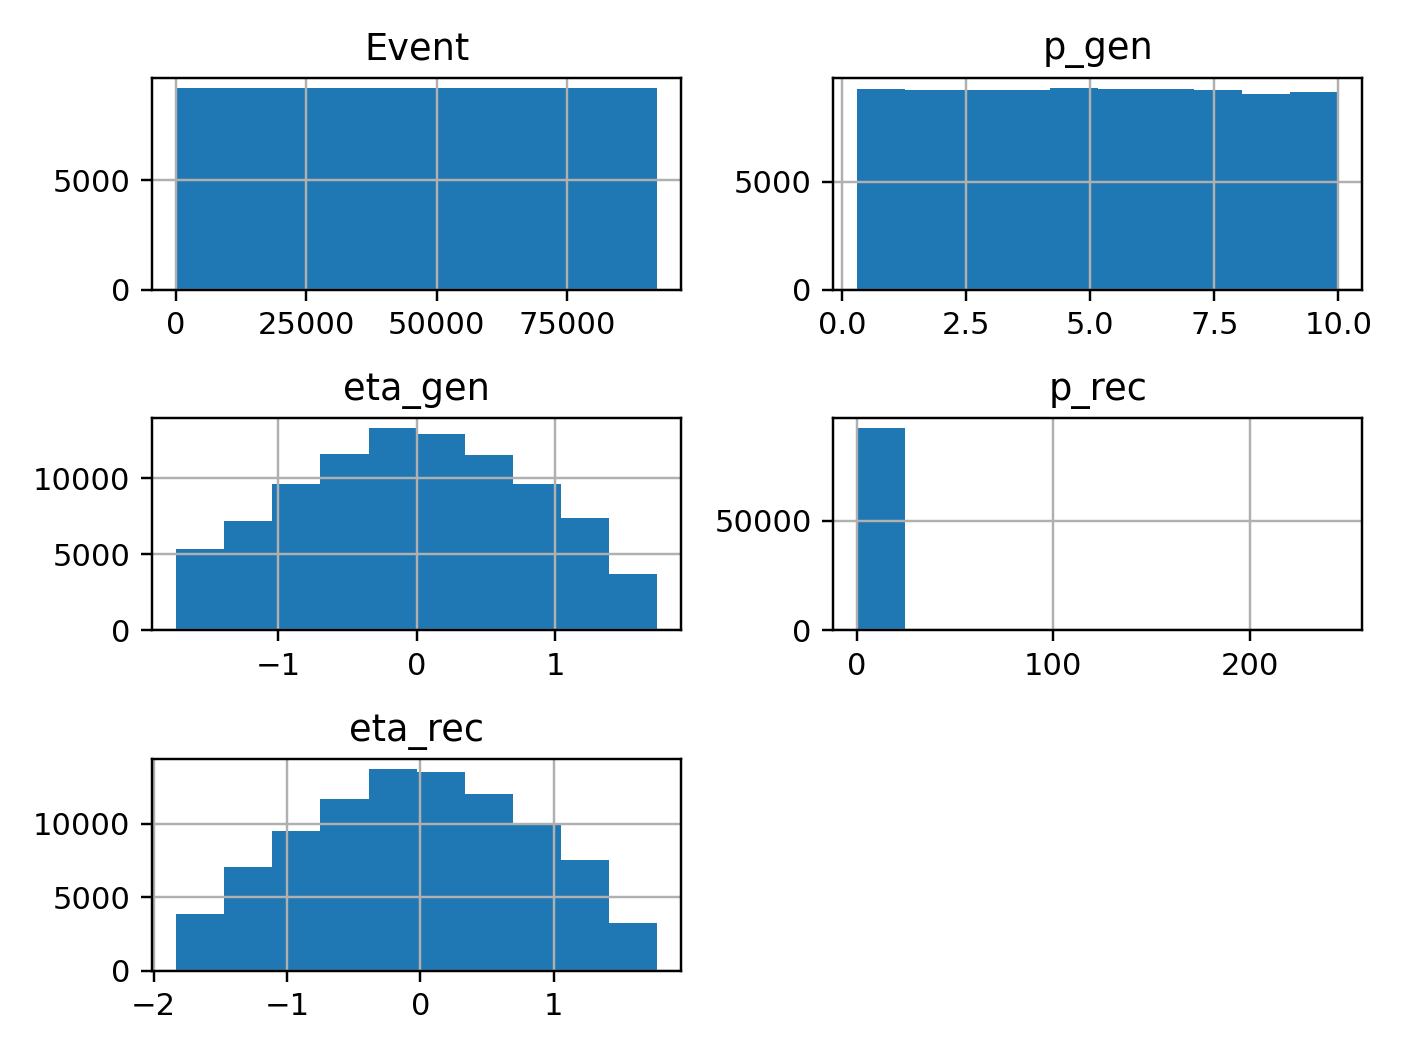

In [4]:
#2
ax = df.hist()
plt.tight_layout();


In [5]:
df.corr()

,Event,p_gen,eta_gen,p_rec,eta_rec
Event,1.000000,-0.003699,-0.000766,-0.001957,-0.000764
p_gen,-0.003699,1.000000,0.005566,0.929444,0.005553
eta_gen,-0.000766,0.005566,1.000000,0.006302,0.999996
p_rec,-0.001957,0.929444,0.006302,1.000000,0.006292
eta_rec,-0.000764,0.005553,0.999996,0.006292,1.000000


The following show strong correlations:
- p_rec and p_gen (0.929444)
- eta_gen and eta_rec (0.999996)

# Problem 1C)
Visualize the correlation by generating a heatmap of the correlation table. To do this we will use the Seaborn heatmap method *heatmap*

Your heatmap should look something like: 
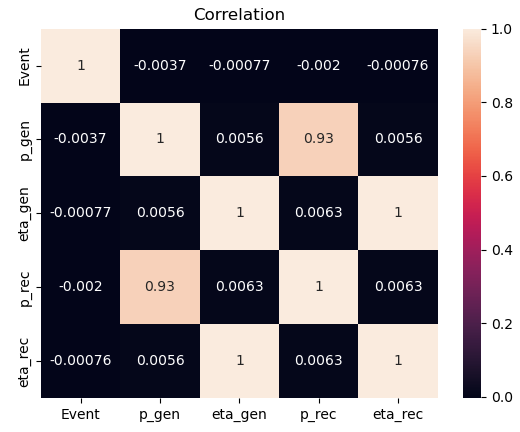

<IPython.core.display.Javascript object>


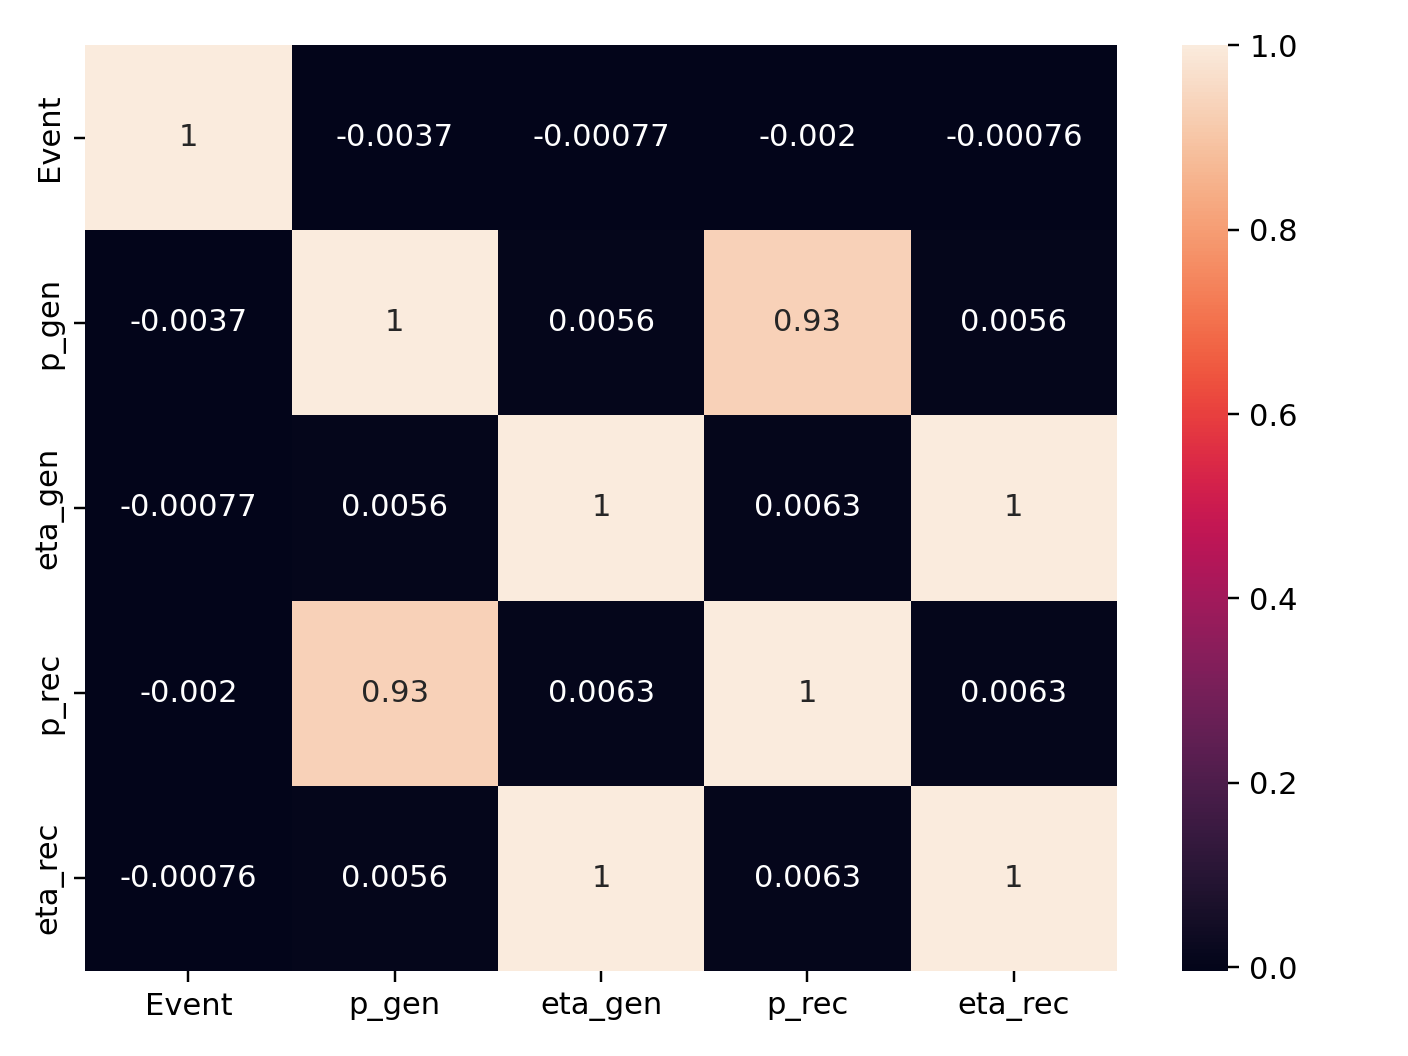

In [6]:
fig = plt.figure()
sns.heatmap(df.corr(), annot=True)
plt.tight_layout();

# Problem 2A)

In this assignment we will assess the tracking performance by calculating the momentum resolution. 
Define a new series in the DataFrame that calculates the momentum resolution and name it *p\_diff*, which should be defiend as
$$ \mathrm{p\_diff} = 100*(\mathrm{p\_rec} - \mathrm{p\_gen})/\mathrm{p\_gen} $$ 

This will give the difference between the reconstructed and generated momentum in percent.

Verify that this quantity is now defined and populated in your DataFrame.

In [7]:
df_new = df.copy()
df_new
df_new['p_diff'] = 100*((df['p_rec']- df['p_gen'])/df['p_gen'])
df_new

,Event,p_gen,eta_gen,p_rec,eta_rec,p_diff
0,0,1.3154,0.3127,1.3160,0.3127,0.045614
1,1,6.3253,-0.6326,6.3514,-0.6327,0.412629
2,2,5.0703,0.1224,5.0936,0.1224,0.459539
3,3,1.5437,0.7066,1.5433,0.7064,-0.025912
4,4,2.3808,-0.4544,2.3632,-0.4542,-0.739247
...,...,...,...,...,...,...
92288,92288,6.4992,0.0144,6.4060,0.0144,-1.434023
92289,92289,8.8592,-0.6944,8.8872,-0.6942,0.316056
92290,92290,3.5989,0.5254,3.5642,0.5255,-0.964184
92291,92291,3.9749,-1.3634,3.9016,-1.3628,-1.844072


# Problem 2B)
1. Generate a histogram of the momentum difference. When creating the histogram use 100 bins and histogram range from -1% to +1%. Hint: Look at the matplotlib *hist()* method reference to see how to specify a histogram bin range.

2. Create x, y, and y_error arrays, where x contains the bin centers of the histogram bins, y is the counts in each bin, and y_error is the square root of the counts in each bin (e.g. $\sqrt{y}$). These will be used later for fitting purposes. 

<IPython.core.display.Javascript object>


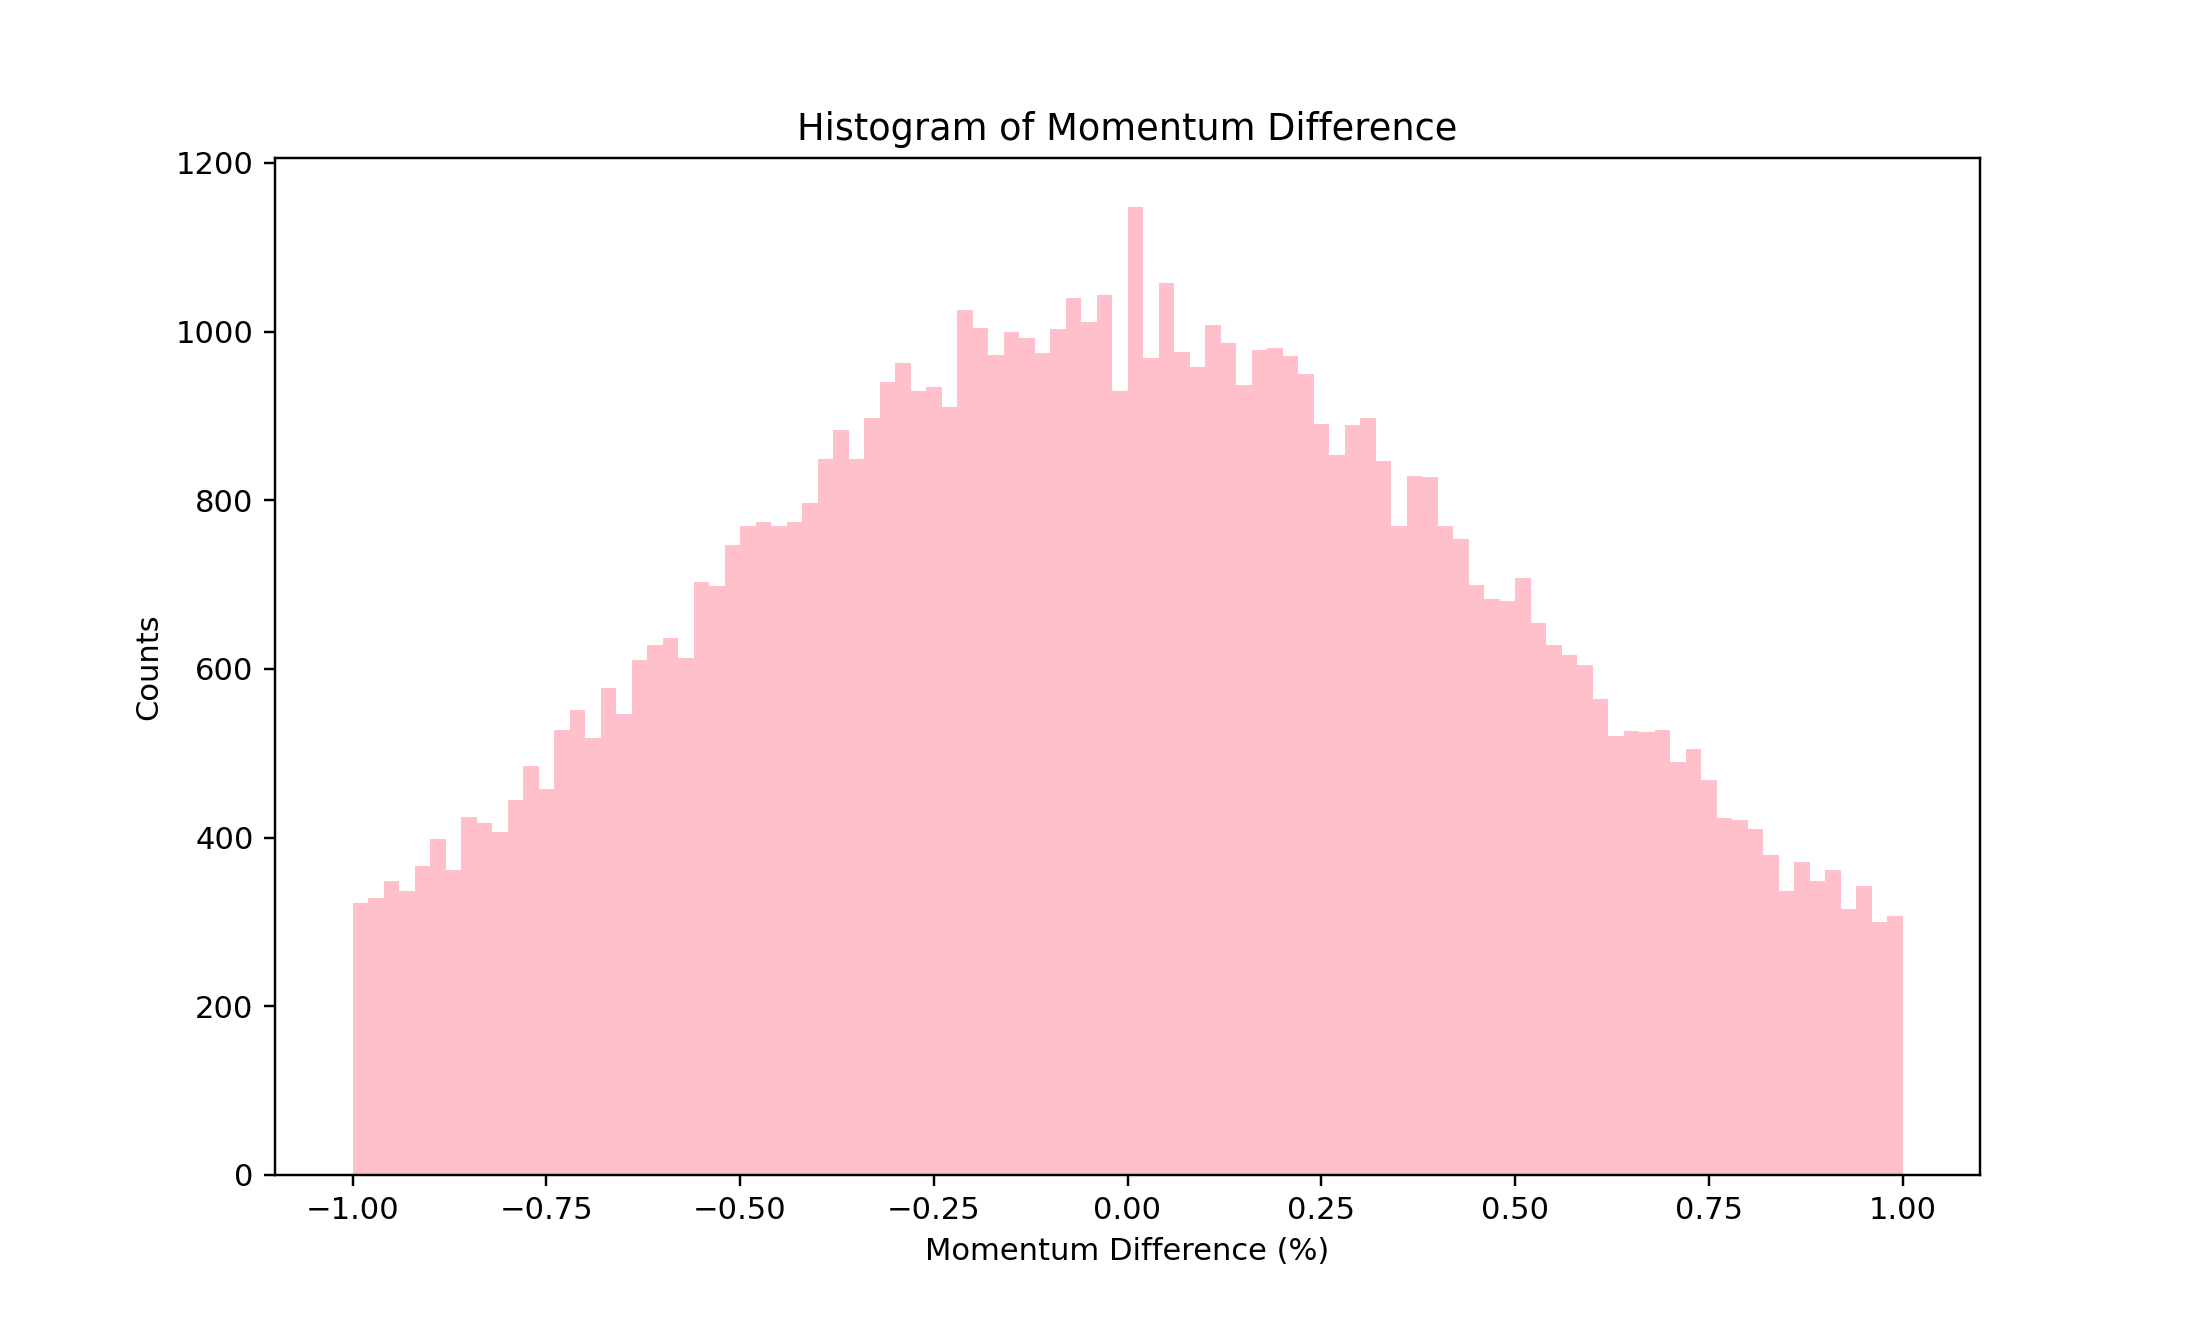

In [8]:
#1
n_bins = 100
hist_range = (-1, 1)

plt.figure(figsize=(10, 6))
plt.hist(df_new['p_diff'], bins=n_bins, range=hist_range, color='pink')

plt.xlabel('Momentum Difference (%)')
plt.ylabel('Counts')
plt.title('Histogram of Momentum Difference')

plt.show()

In [9]:
#2
y, bin_edges = np.histogram(df_new['p_diff'], bins=n_bins, range=hist_range)
x = 0.5 * (bin_edges[:-1] + bin_edges[1:])
y_error = np.sqrt(y)

# Problem 3A)

The momentum distribution appears to follow a Gaussian distribution, and so the momnetum resolution provided by the tracking system can be calculated from the width of the distribution. We will fit the momentum distribution with a Gaussian function and extract the value of the Gaussian $\sigma$, which is the momentum resolutuon of the tracking system.

1. Define a function that returns a value computed from a Gaussian distribution. The Gaussian function should have the form:
$$ G(x) =  p_1 e^{-(x-p_2)^2/(2p_3)}$$,

where $x$ will be the momentum difference, $p_1,p_2,$ and $p_3$ are parameters determining the specific form of the Gaussian curve which will be optimized during fitting of the momentum difference distribution.

Your function should take x, p_1, p_2, and p_3 as arguments and return the output of $G(x)$.

In [10]:
def gaussian(x, p_1, p_2, p_3):
    return p_1 * np.exp(-(x - p_2)**2 / (2 * p_3**2))

# Problem 3B)

Starting with the inital paramters $$p1=500, p2=0, p3=1$$ ,fit the momentum difference distribution using *curve_fit* from the Scipy library.

**Q: What is the momentum resolution?** 

In [11]:
x_data = x  
y_data = y

initial_params = [500, 0, 1]

fit_params, covariance = curve_fit(gaussian, x_data, y_data, p0=initial_params)

p1_fit, p2_fit, p3_fit = fit_params

momentum_resolution = p3_fit

print('Momentum Resolution:', momentum_resolution)

Momentum Resolution: 0.6105187259626701


# Problem 3C)
1. Draw a histogram of the distribution with the fit result drawn on as well.
2. Calculate the reduced $\chi^2$ of the fit.
3. Calculate the p-value of the fit.
**Q: Does the fit do a good job describing the data within the $\pm1\%$ range? Explain**
Fitted histogram over $\pm1 \%$ range should look like this:
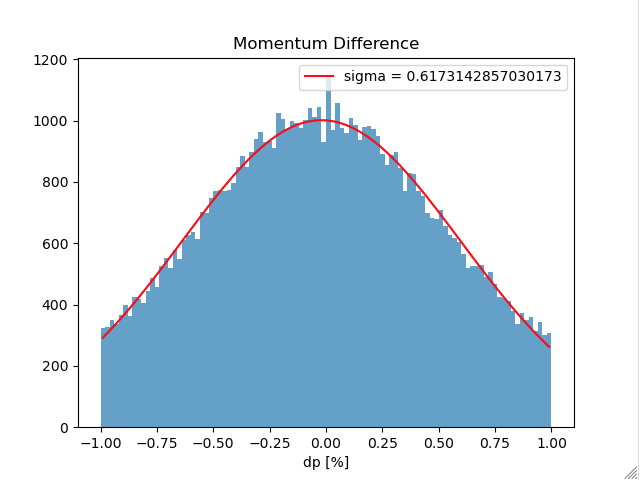

**Q: What happens to how the fit describes the data if we open up the range to cover from -5% to 5%, is it worst or better? What does this say about our assumption that the distribution is purely Gaussian?**

<IPython.core.display.Javascript object>


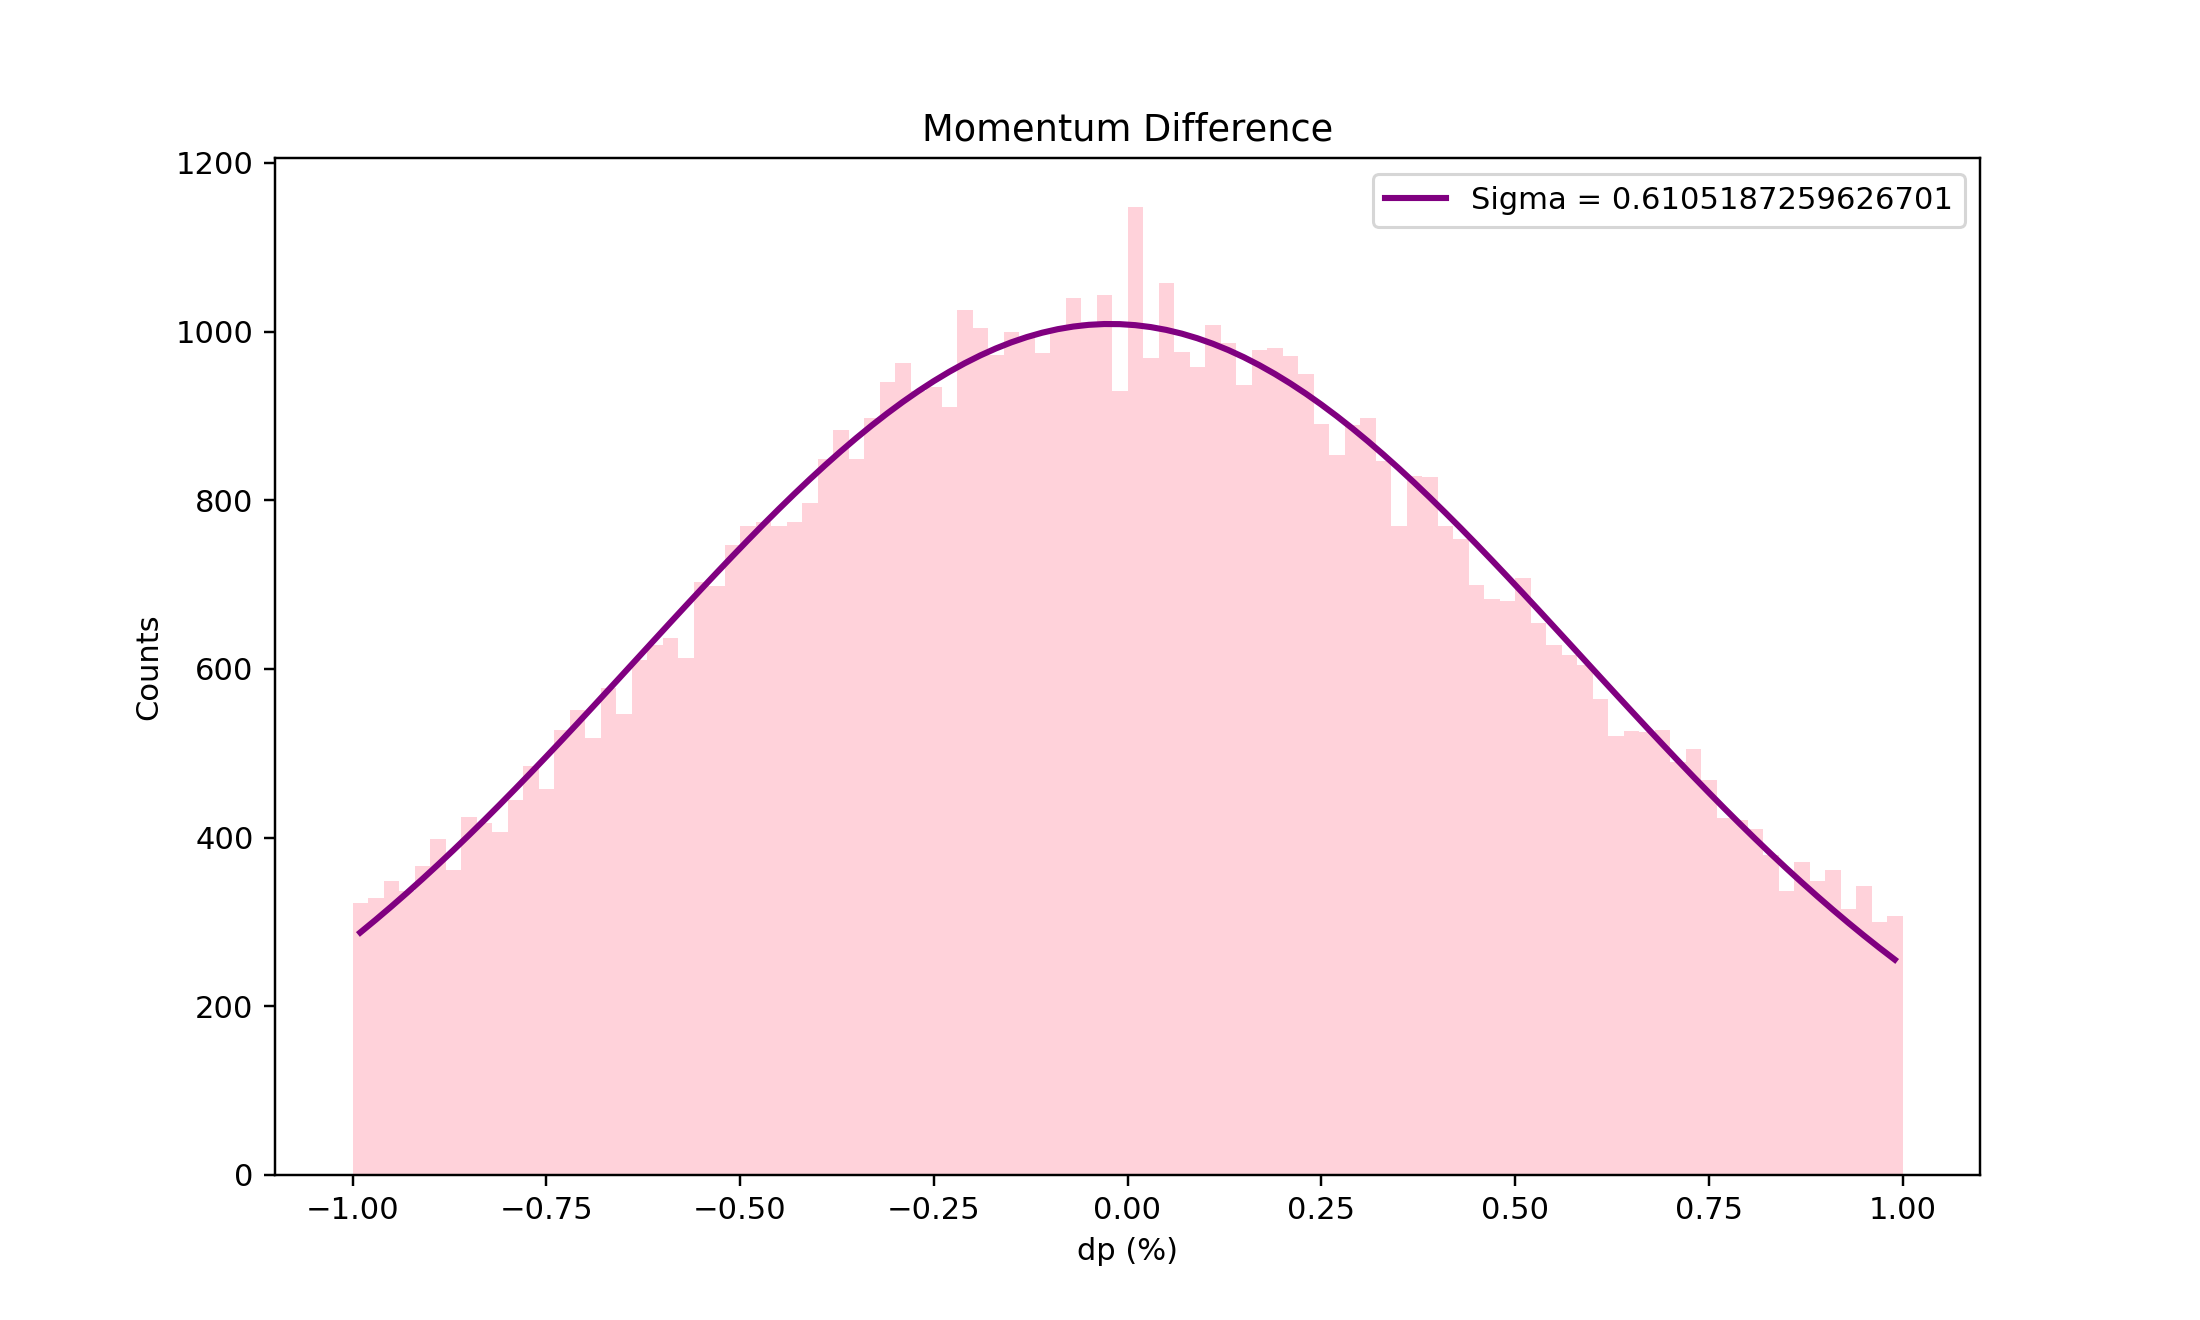

In [12]:
#1
y_fit = gaussian(x_data, *fit_params)

plt.figure(figsize=(10, 6))
plt.hist(df_new['p_diff'], bins=n_bins, range=hist_range, alpha=0.7, color= 'pink')
plt.plot(x_data, y_fit, label=f'Sigma = {p3_fit:}', linewidth=2, color= 'purple')

plt.xlabel('dp (%)')
plt.ylabel('Counts')
plt.title('Momentum Difference')
plt.legend()
plt.show()

In [13]:
#2
chi_squared = np.sum(((y_data - y_fit) / y_error)**2)
dof = len(x_data) - len(fit_params)

reduced_chi_squared = chi_squared / dof
print(f"Reduced chi-squared: {reduced_chi_squared}")

Reduced chi-squared: 1.5870481365344862


In [14]:
#3
p_value = sf.gammaincc(dof / 2.0, chi_squared / 2.0)
print(f"P-value: {p_value}")

P-value: 0.00020747597949461496


Q: Does the fit do a good job describing the data within the  ±1% range? Explain

ANSWER: Because the p-value is close to 0 (less than 0.05), it suggests that the Gaussian distribution is a bad description of the data within the this range.

Q: What happens to how the fit describes the data if we open up the range to cover from -5% to 5%, is it worst or better? What does this say about our assumption that the distribution is purely Gaussian?

ANSWER: If I go up to 2b and alter the range, I get a rounded p-value of 0. This is worse, meaning that this distribution should not be assumed as purely gaussian. 

# Problem 4A)

In Problem 3 we computed the momentum resolution by integrating over the entire momentum and $\eta$ range. However, the tracking performance could change as function of both momentum and $\eta$. 

To access how the momentum resolution changes as a function of $\eta$, we will split our *p_diff* values into three $\eta$ regions:
* Backward: $\eta < -1$
* Central: $|\eta| < 1$
* Forward: $\eta > 1$

Create three new DataFrames that contain the momentum difference values for the specified $\eta$ ranges and then create histograms showing the momentum difference in each of these $\eta$ regions. When working with the $\eta$ values, use eta_gen values.

<IPython.core.display.Javascript object>


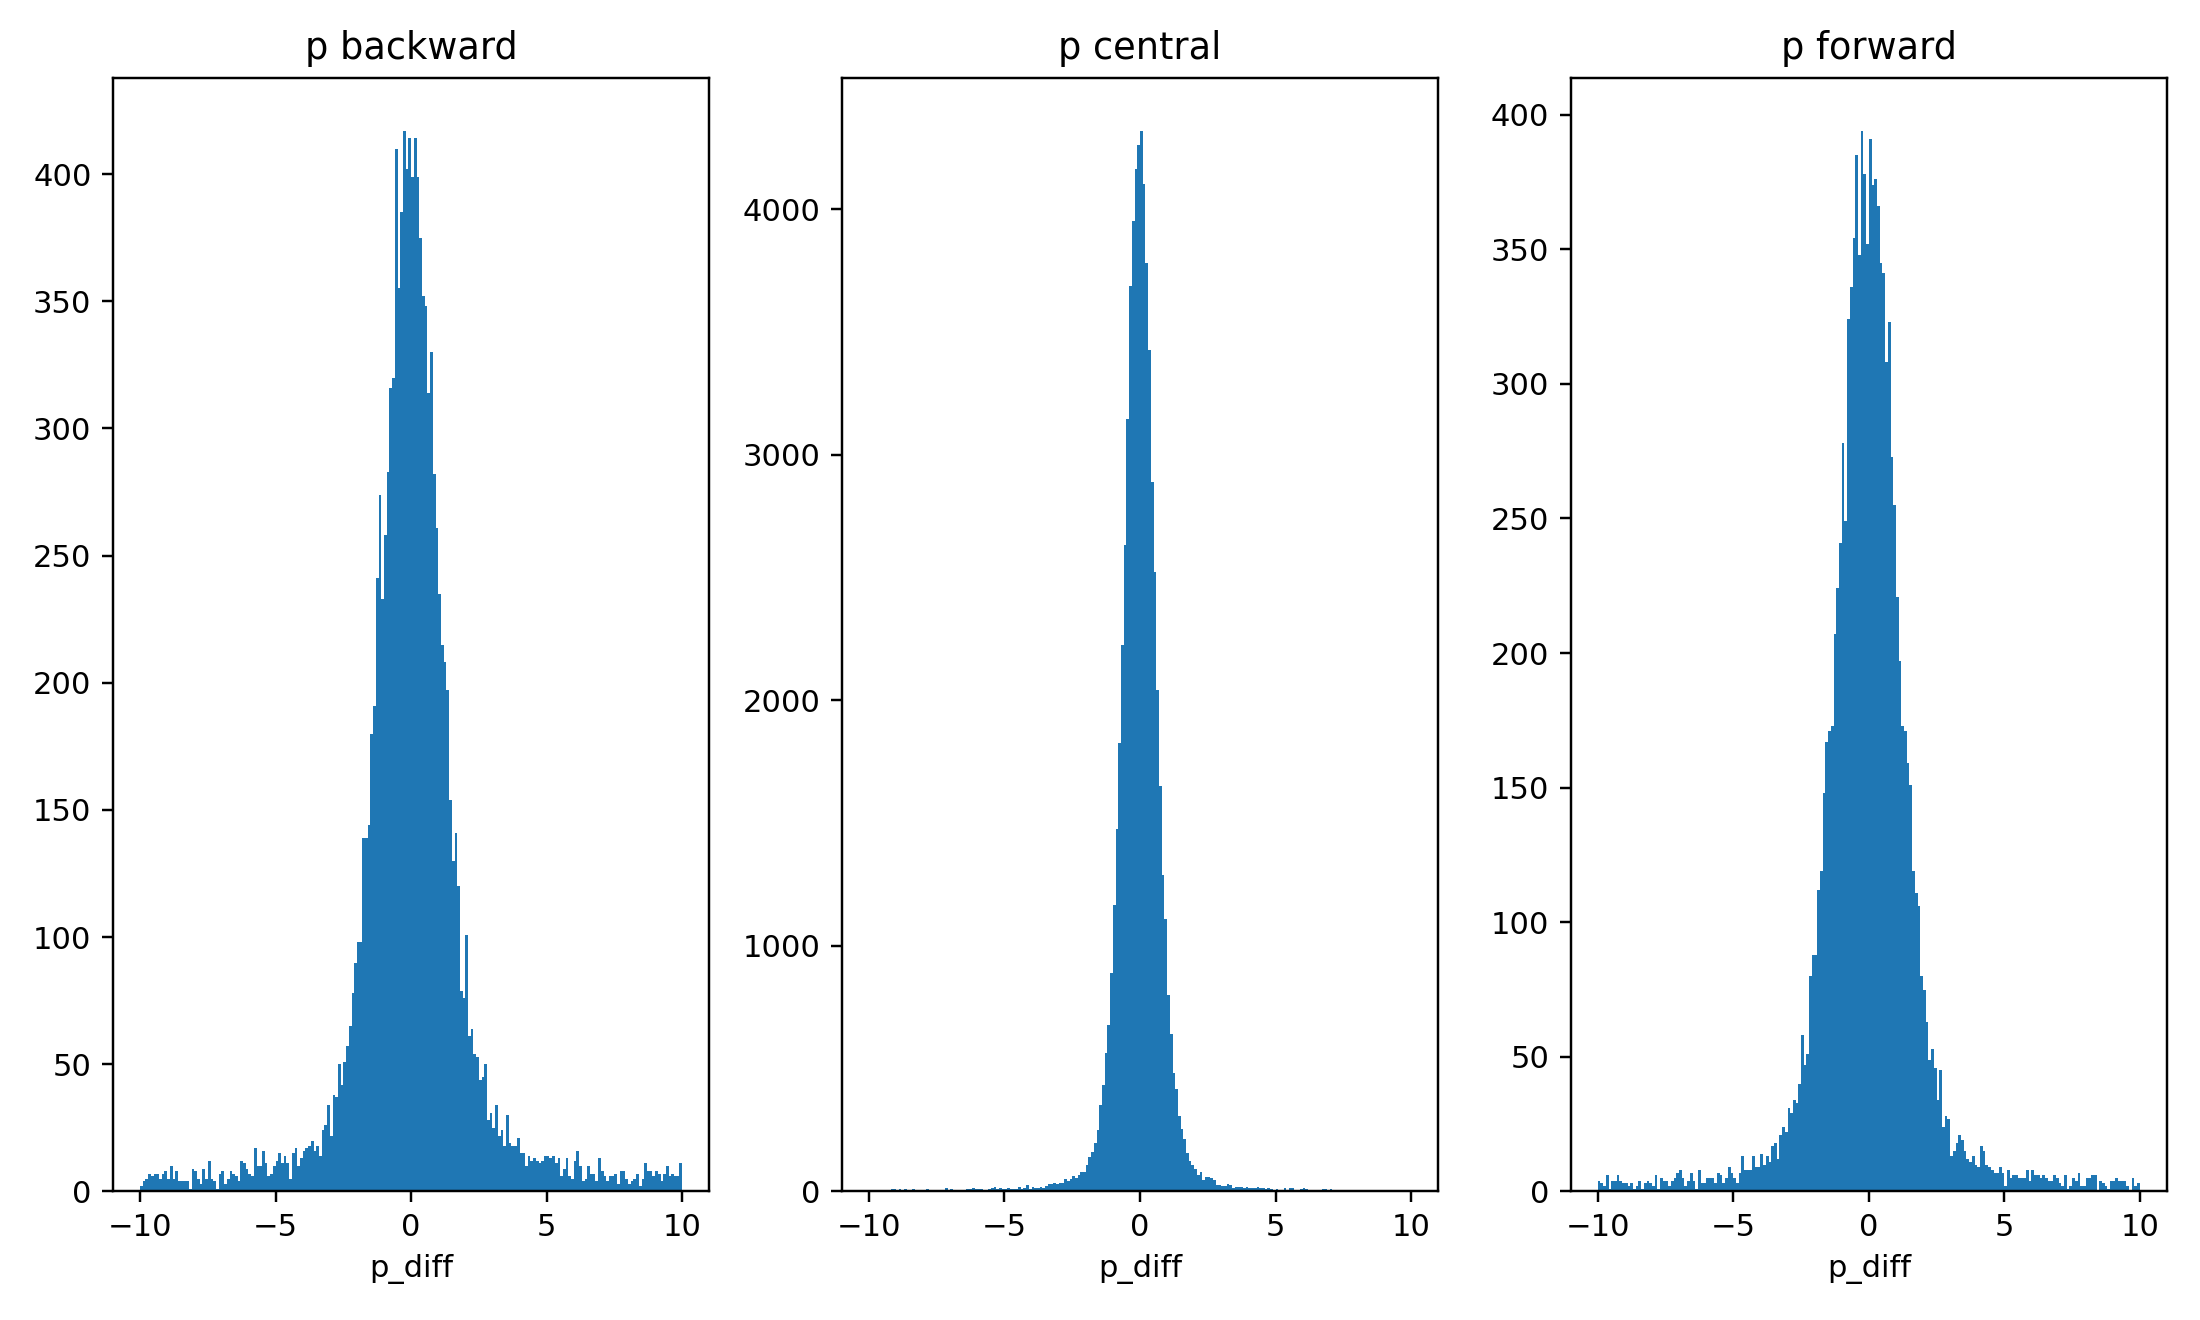

In [19]:
p_backward = df_new[df_new['eta_gen'] < -1]
p_central = df_new[(df_new['eta_gen'] >= -1) & (df_new['eta_gen'] <= 1)]
p_forward = df_new[df_new['eta_gen'] > 1]

fig, axs = plt.subplots(1, 3, figsize=(10, 6))

axs[0].hist(p_backward['p_diff'], bins=200, range=(-10, 10))
axs[0].set_title('p backward')
axs[1].hist(p_central['p_diff'], bins=200, range=(-10, 10))
axs[1].set_title('p central')
axs[2].hist(p_forward['p_diff'], bins=200, range=(-10, 10))
axs[2].set_title('p forward')

for ax in axs:
    ax.set_xlabel('p_diff')

plt.tight_layout()
plt.show()

# Problem 4B)

Fit each of the 3 $\eta$ regions with a Gaussian function to get a more quantatative idea of how the resolution changes as a function of $\eta$. For this fit you can use the range -5% to 5% and **do not** need to calculate $\chi^2$ or a p-value for this problem.

Your 3 fitted histograms shoul look like this:
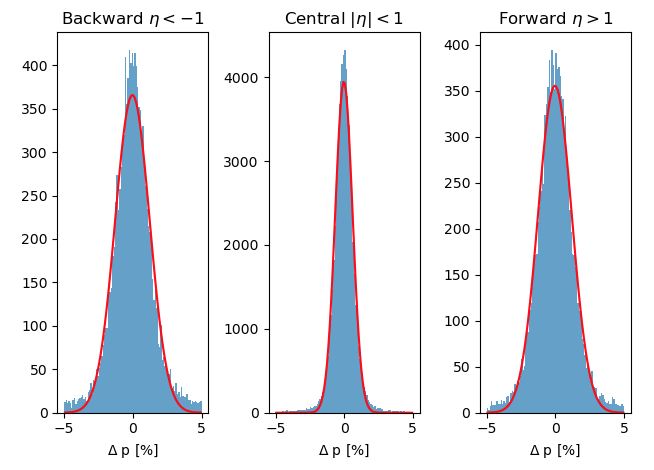

**Q: What region provides the best momentum resolution?** 

**Q: What region provides the worst momentum resolution?** 

<IPython.core.display.Javascript object>


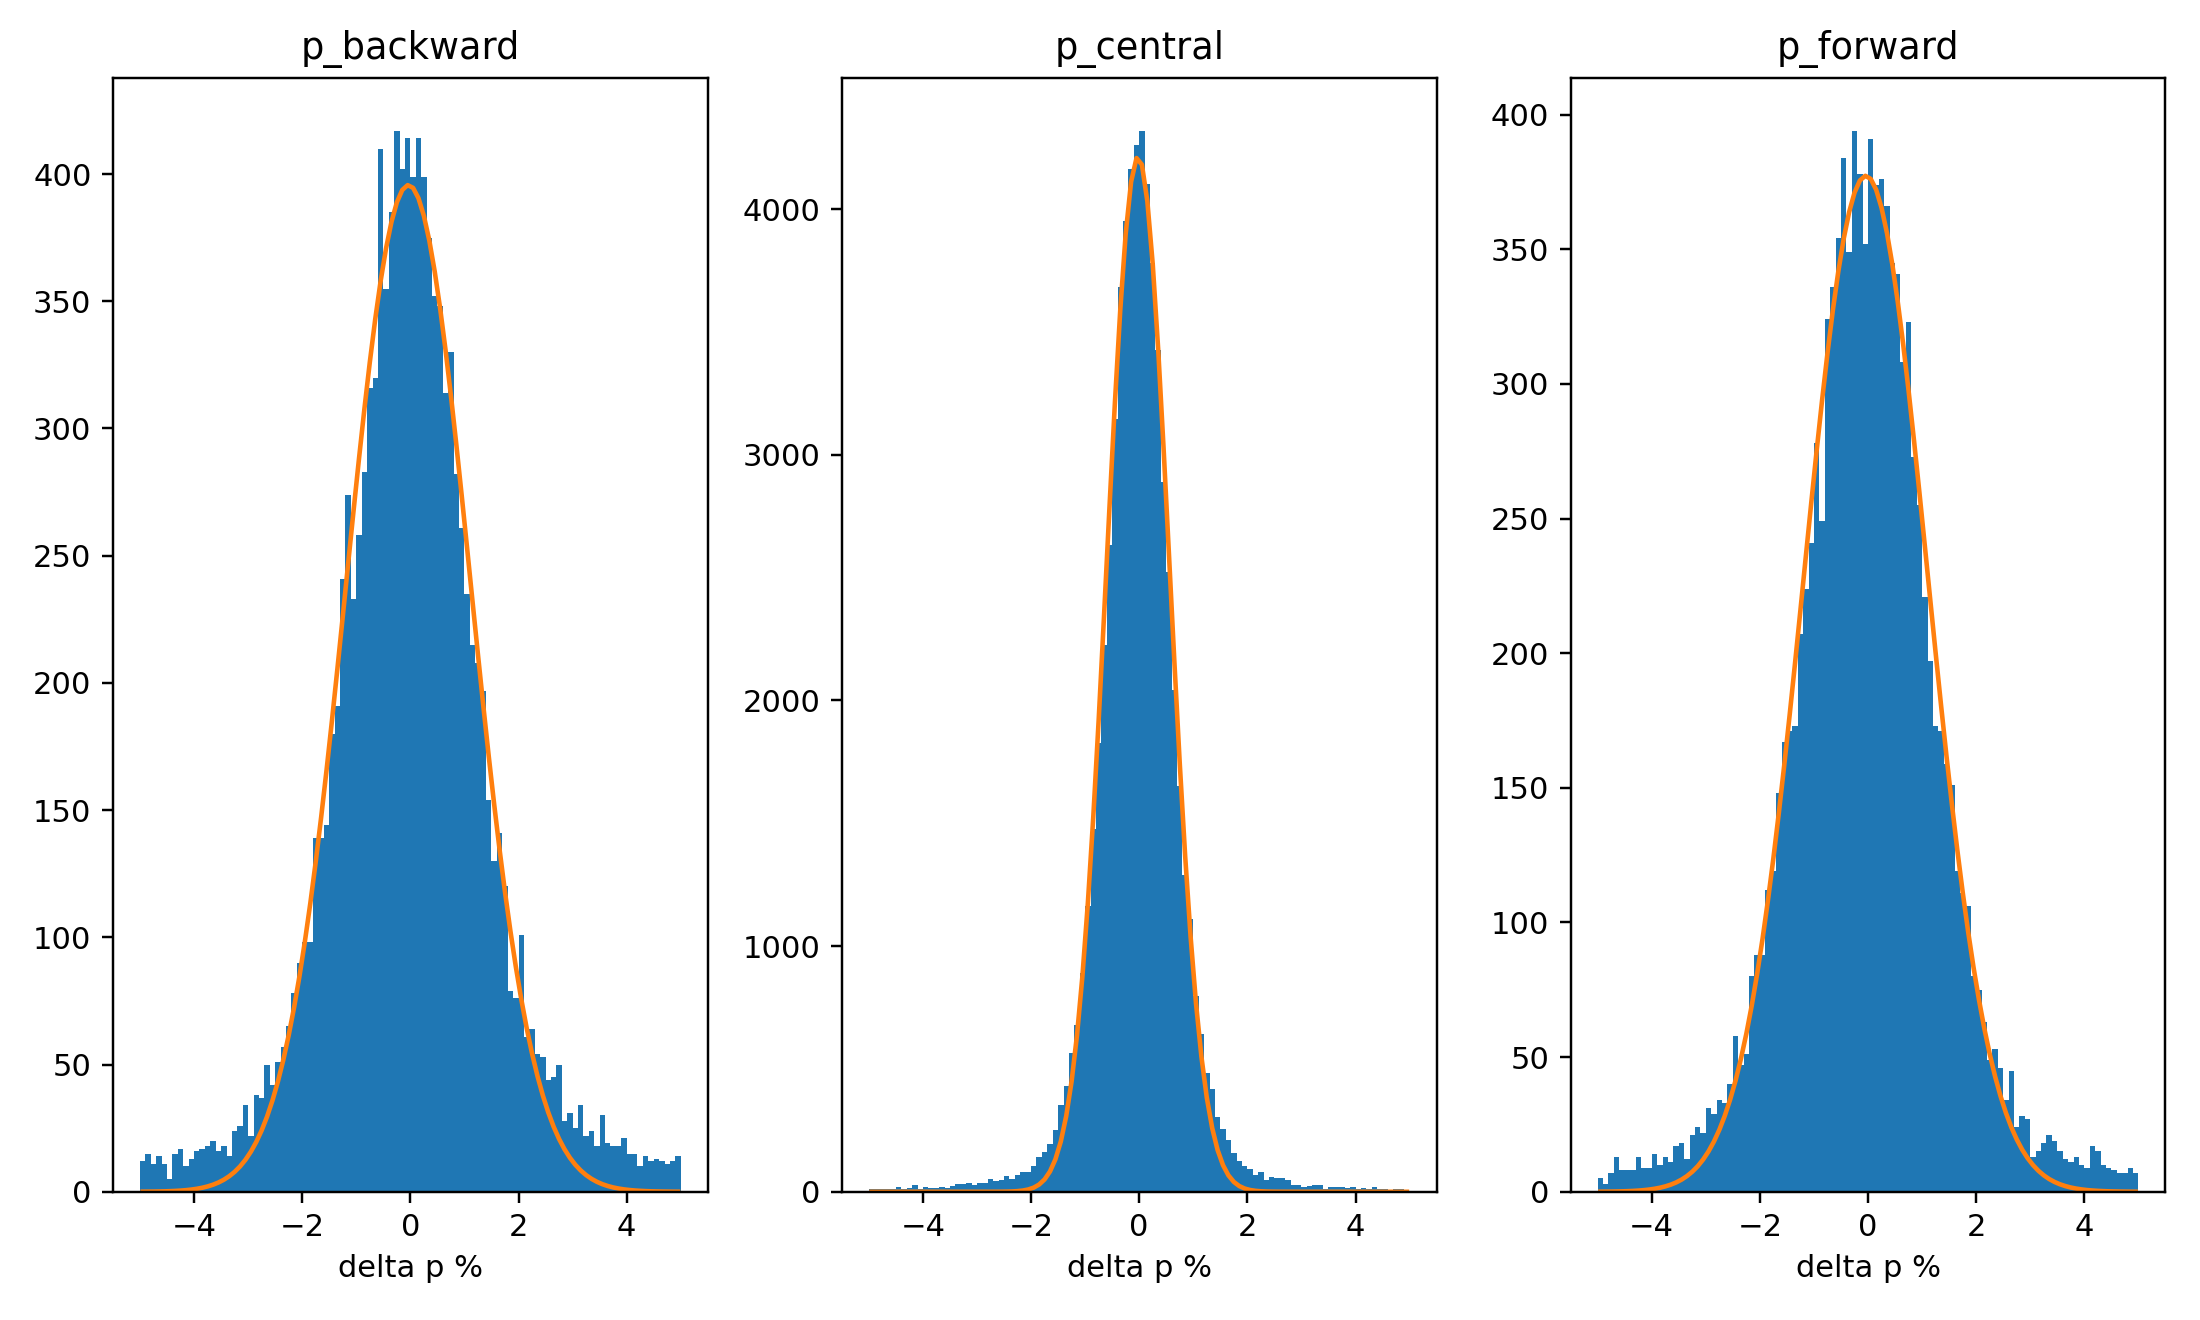

In [20]:
p_diff_back = p_backward['p_diff']
hist_back, bins_back = np.histogram(p_diff_back, bins=100, range=(-5, 5))
bin_centers_back = (bins_back[:-1] + bins_back[1:]) / 2
popt_back, _ = curve_fit(gaussian, bin_centers_back, hist_back, p0=(1000, 0, 5))


plt.figure(figsize=(10, 6))
plt.subplot(131)
plt.hist(p_diff_back, bins=100, range=(-5, 5))
plt.plot(bin_centers_back, gaussian(bin_centers_back, *popt_back))
plt.title('p_backward')
plt.xlabel('delta p %')

p_diff_central = p_central['p_diff']
hist_central, bins_central = np.histogram(p_diff_central, bins=100, range=(-5, 5))
bin_centers_central = (bins_central[:-1] + bins_central[1:]) / 2

popt_central, _ = curve_fit(gaussian, bin_centers_central, hist_central, p0=(1000, 0, 5))

plt.subplot(132)
plt.hist(p_diff_central, bins=100, range=(-5, 5))
plt.plot(bin_centers_central, gaussian(bin_centers_central, *popt_central))
plt.title('p_central')
plt.xlabel('delta p %')

p_diff_forward = p_forward['p_diff']
hist_forward, bins_forward = np.histogram(p_diff_forward, bins=100, range=(-5, 5))
bin_centers_forward = (bins_forward[:-1] + bins_forward[1:]) / 2

popt_forward, _ = curve_fit(gaussian, bin_centers_forward, hist_forward, p0=(1000, 0, 5))

plt.subplot(133)
plt.hist(p_diff_forward, bins=100, range=(-5, 5))
plt.plot(bin_centers_forward, gaussian(bin_centers_forward, *popt_forward))
plt.title('p_forward')
plt.xlabel('delta p %')

plt.tight_layout()
plt.show()

In [21]:
print('p backward:', popt_back[2])
print('p central:',popt_central[2])
print('p forward:',popt_forward[2])

p backward: 1.1475426476811594
p central: 0.5807798691900943
p forward: 1.1457778510424002


Q: What region provides the best momentum resolution?
ANSWER: The central region provides the best resolution because the error in measurement is about 0.58%, which is the smallest the 3 regions.  

Q: What region provides the worst momentum resolution?
ANSWER: The backward region is the worst at ~1.148%, which is only slightly less precise than the foward region with a value of 1.146%.

# Problem 5A)

In Problem 4 we investigated how the momentum resolution changes as a function of $\eta$. The momentum resolution is also dependent on the momentum of the particle being detectoed. In this problem we will look at the momentum dependence of the momentum resolution.

To access how the momentum resolution changes as a function of *p_gen*, we will split our *p_diff* values into three 5 momentum regions: (0,2), (2,4), (4,6), (6,8), (8,10)

Create five new DataFrames that contain the momentum difference values for the specified *p_gen* ranges and then create histograms showing the momentum difference in each of these p_gen regions. 

<IPython.core.display.Javascript object>


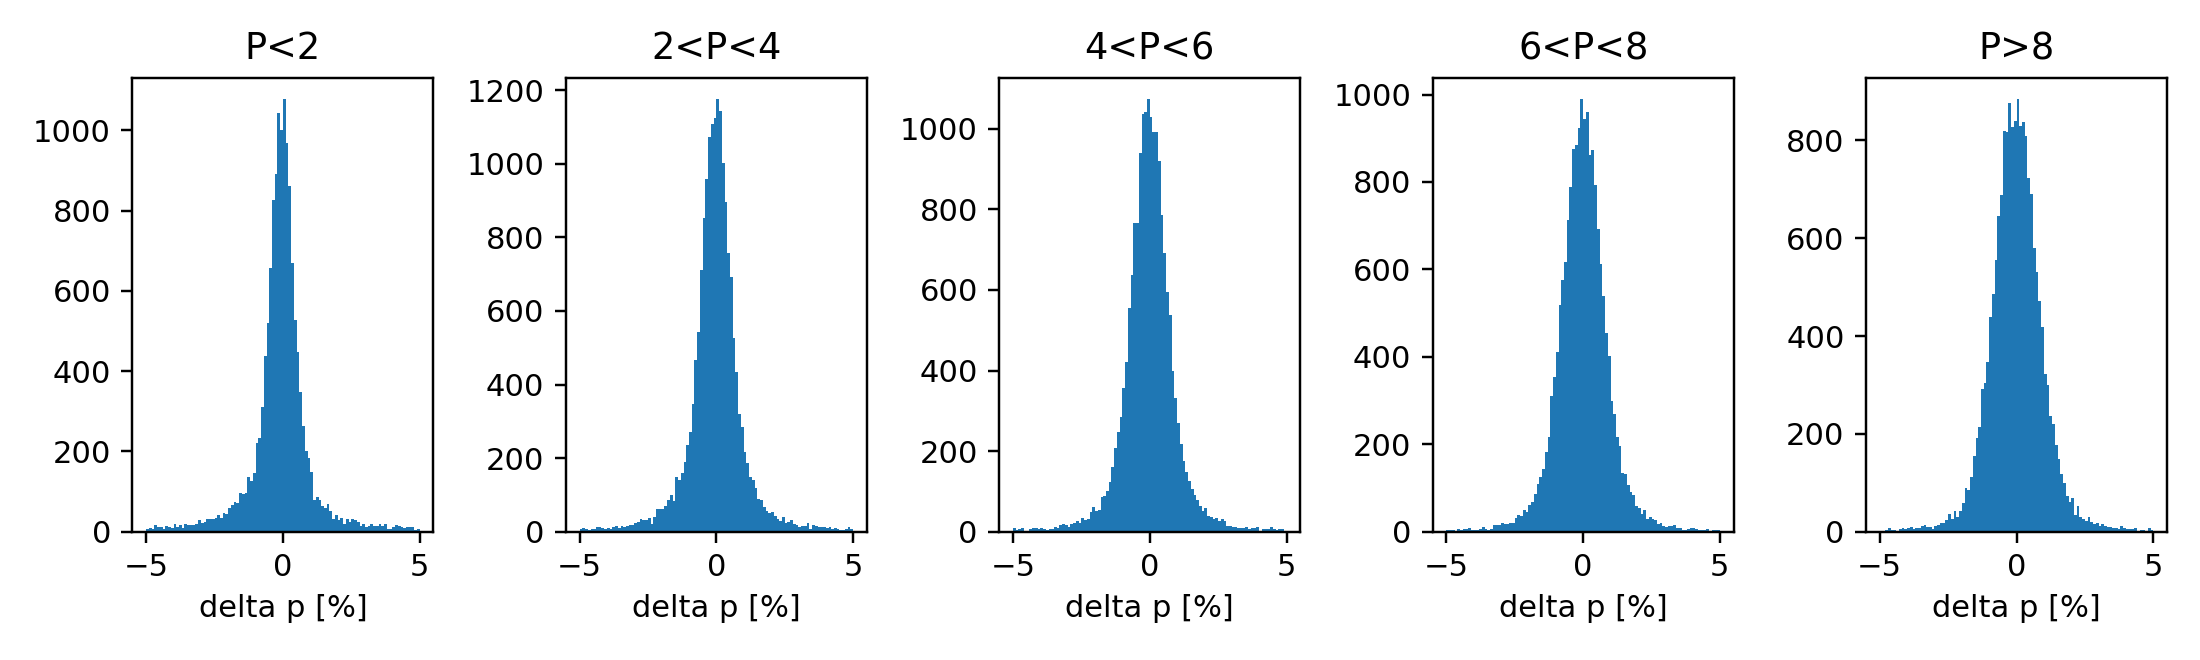

In [22]:
df_02 = df_new[(df_new['p_gen'] >= 0) & (df_new['p_gen'] < 2)]
df_24 = df_new[(df_new['p_gen'] >= 2) & (df_new['p_gen'] < 4)]
df_46 = df_new[(df_new['p_gen'] >= 4) & (df_new['p_gen'] < 6)]
df_68 = df_new[(df_new['p_gen'] >= 6) & (df_new['p_gen'] < 8)]
df_810 = df_new[(df_new['p_gen'] >= 8) & (df_new['p_gen'] < 10)]



fig, axs = plt.subplots(1, 5, figsize=(10, 3))

axs[0].hist(df_02['p_diff'], bins=100, range=(-5, 5))
axs[0].set_title('P<2')
axs[1].hist(df_24['p_diff'], bins=100, range=(-5, 5))
axs[1].set_title('2<P<4')
axs[2].hist(df_46['p_diff'], bins=100, range=(-5, 5))
axs[2].set_title('4<P<6')
axs[3].hist(df_68['p_diff'], bins=100, range=(-5, 5))
axs[3].set_title('6<P<8')
axs[4].hist(df_810['p_diff'], bins=100, range=(-5, 5))
axs[4].set_title('P>8')

for ax in axs:
    ax.set_xlabel('delta p [%]')

plt.tight_layout()
plt.show()

# Problem 5B)

Fit each of the 5 momentum regions with a Gaussian function to get a more quantatative idea of how the resolution changes as a function of p_gen. For this fit you can use the range -5% to 5% and **do not** need to calculate $\chi^2$ or a p-value for this problem.

Your 5 fitted histograms should look like this:
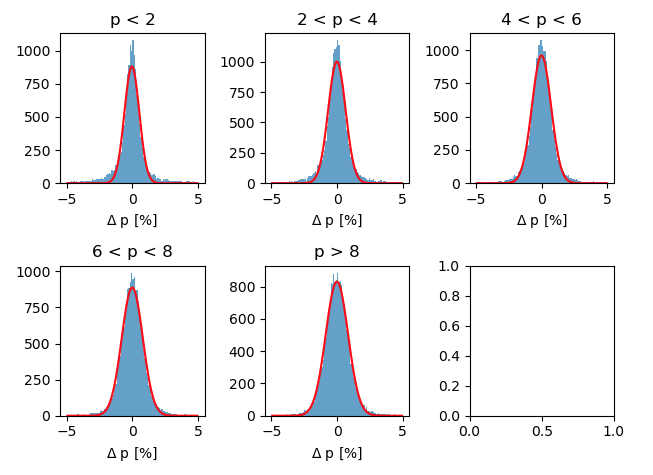

**Q: What region provides the best momentum resolution?**

**Q: What region provides the worst momentum resolution?**


<IPython.core.display.Javascript object>


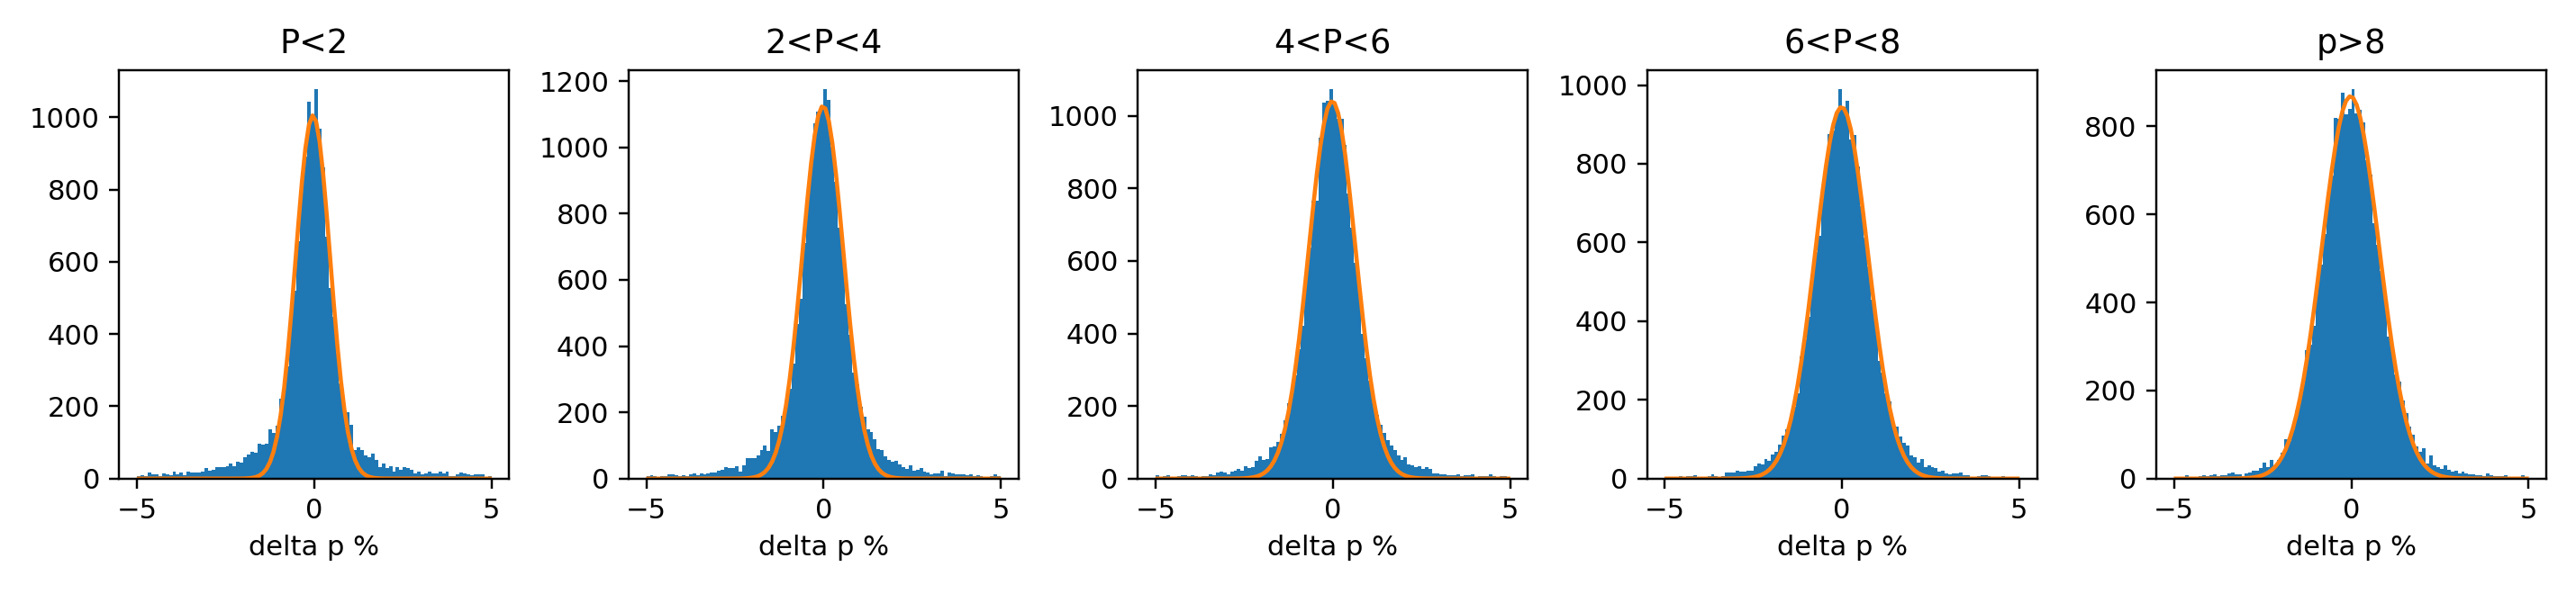

In [23]:
hist_02, bins_02 = np.histogram(df_02['p_diff'], bins=100, range=(-5, 5))
bin_centers_02 = (bins_02[:-1] + bins_02[1:]) / 2
popt_02, _ = curve_fit(gaussian, bin_centers_02, hist_02,  p0=(1000, 0, 5))

fig = plt.figure(figsize=(13, 3))

plt.subplot(151)
plt.hist(df_02['p_diff'], bins=100, range=(-5, 5))
plt.plot(bin_centers_02, gaussian(bin_centers_02, *popt_02))
plt.title('P<2')
plt.xlabel('delta p %')

####

hist_24, bins_24 = np.histogram(df_24['p_diff'], bins=100, range=(-5, 5))
bin_centers_24 = (bins_24[:-1] + bins_24[1:]) / 2
popt_24, _ = curve_fit(gaussian, bin_centers_24, hist_24,  p0=(1000, 0, 5))

plt.subplot(152)
plt.hist(df_24['p_diff'], bins=100, range=(-5, 5))
plt.plot(bin_centers_24, gaussian(bin_centers_24, *popt_24))
plt.title('2<P<4')
plt.xlabel('delta p %')

#####

hist_46, bins_46 = np.histogram(df_46['p_diff'], bins=100, range=(-5, 5))
bin_centers_46 = (bins_46[:-1] + bins_46[1:]) / 2
popt_46, _ = curve_fit(gaussian, bin_centers_46, hist_46,  p0=(1000, 0, 5))

plt.subplot(153)
plt.hist(df_46['p_diff'], bins=100, range=(-5, 5))
plt.plot(bin_centers_46, gaussian(bin_centers_46, *popt_46))
plt.title('4<P<6')
plt.xlabel('delta p %')

#####

hist_68, bins_68 = np.histogram(df_68['p_diff'], bins=100, range=(-5, 5))
bin_centers_68 = (bins_68[:-1] + bins_68[1:]) / 2
popt_68, _ = curve_fit(gaussian, bin_centers_68, hist_68,  p0=(1000, 0, 5))

plt.subplot(154)
plt.hist(df_68['p_diff'], bins=100, range=(-5, 5))
plt.plot(bin_centers_68, gaussian(bin_centers_68, *popt_68))
plt.title('6<P<8')
plt.xlabel('delta p %')

######
hist_810, bins_810 = np.histogram(df_810['p_diff'], bins=100, range=(-5, 5))
bin_centers_810 = (bins_810[:-1] + bins_810[1:]) / 2
popt_810, _ = curve_fit(gaussian, bin_centers_810, hist_810,  p0=(1000, 0, 5))

plt.subplot(155)
plt.hist(df_810['p_diff'], bins=100, range=(-5, 5))
plt.plot(bin_centers_810, gaussian(bin_centers_810, *popt_810))
plt.title('p>8')
plt.xlabel('delta p %')


plt.tight_layout()
plt.show()

In [24]:
print('p<2:', popt_02[2])
print('2<p<4:',popt_24[2])
print('4<p<6:',popt_46[2])
print('6<p<8:', popt_68[2])
print('p>8:',popt_810[2])

p<2: 0.48738180284459753
2<p<4: 0.5777931075844834
4<p<6: 0.6616091028126568
6<p<8: 0.7454431864647825
p>8: 0.8069553464975124


Q: What region provides the best momentum resolution?

ANSWER:  The region p<2 since the percent error is 0.487%, which is the lowest of all 5. 

Q: What region provides the worst momentum resolution?

ANSWER: The region p>8 since the percent error is 0.807%, which is the highest of all 5. 